In [24]:
import pandas as pd
import numpy as np
from bioinfokit.analys import norm
from rpy2 import robjects
from rpy2.robjects import r,pandas2ri
from rpy2.robjects.packages import importr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn.decomposition import PCA
import shap
from sklearn.tree import DecisionTreeClassifier, plot_tree
import math
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [16]:
cnt= pd.read_csv("count_IMvigor210_N298.csv", header=0,index_col=0) 
metadata = pd.read_csv("metadata_IMvigor210_N298.csv", header=0)
nm = norm()
nm.tpm(df=cnt, gl='Length')
tpm = nm.tpm_norm
tpm = tpm[~tpm.index.duplicated()]
tpm = tpm.dropna()
tpm = tpm[tpm.mean(axis=1) >= 0]
##########
sam_1 = metadata[metadata["label"] == 1]["id"].tolist()
sam_0 = metadata[metadata["label"] == 0]["id"].tolist()
sam_all = sam_1 + sam_0
tpm = tpm[sam_all]
tpm = np.log2(tpm + 1)
tpm

,SAMd027124354ce,SAMbf1a3ae828e6,SAM2e9ac0b1b250,SAM30b5c6c54cf7,SAMd35318127278,SAM560f23d6a3ad,SAM73663ee4a96e,SAMc2a1820d4e6b,SAMe1eb5d988760,SAM8a1b0e02ee42,...,SAMf20b827dca51,SAM6792d6e98068,SAM5cc2d9036053,SAM80c6183220e6,SAM1f83ebd6be9b,SAMe7e4f7c076a7,SAMc6eff056c89a,SAM5cfa1699bdb7,SAMda4d892fddc8,SAMe3d4266775a9
A1BG,2.166027,0.508185,3.249488,1.001434,0.685816,1.254024,1.516686,1.034129,0.866157,2.529901,...,1.782505,0.438148,2.425213,1.943651,0.309610,0.548716,0.892466,5.369222,1.896123,2.199709
NAT2,0.134138,0.748001,0.165302,0.000000,0.000000,0.153885,0.115295,0.070641,0.540331,0.568783,...,0.234960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500549,0.000000,0.000000
ADA,4.935398,4.071487,4.225526,5.432950,4.129794,4.980992,4.209972,4.256524,4.560283,4.337712,...,5.430871,1.592323,4.162561,5.658997,2.308445,4.362667,4.102500,2.988546,5.166945,3.602627
CDH2,5.894632,2.319084,5.523936,2.077784,1.375779,4.980792,2.459577,2.647986,2.763013,0.689167,...,1.306843,0.422364,2.477770,2.966589,3.828078,3.330023,2.812540,5.691231,3.779975,2.040872
AKT3,2.810776,3.187945,2.928128,0.994997,0.924988,1.078463,1.650964,2.250768,2.765002,2.245277,...,2.356875,0.890569,2.446137,1.923435,0.992014,1.783858,1.657312,2.843039,1.285258,1.917956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTBP3,4.101352,5.489016,4.618000,5.219849,6.357359,5.239007,4.977425,4.792271,5.997859,4.687192,...,5.783021,5.439531,4.937927,6.034327,6.263501,6.157345,5.639928,5.171114,5.279726,6.228962
KCNE2,0.781676,1.015442,0.675660,0.287310,0.769322,0.127377,0.495034,0.656392,0.615623,0.338230,...,0.521188,0.333590,0.485990,0.533264,0.000000,0.244948,0.000000,0.184022,0.000000,0.187341
DGCR2,3.441991,3.136050,3.162762,2.744280,3.468980,3.614986,4.310776,3.548938,3.216997,3.351975,...,3.050657,3.178082,4.138087,3.366017,2.968049,2.497664,3.205061,3.649210,2.993765,3.882288
CASP8AP2,5.254889,5.269179,4.687361,4.536145,5.904862,4.512455,4.288716,4.856942,5.179028,5.004986,...,4.546669,3.776623,3.627429,4.376403,4.895531,4.304589,4.252124,4.285813,3.395531,5.092525


In [17]:
easyTCGA = importr('easyTCGA')
pandas2ri.activate()
front_columns = tpm.transpose().head(131).transpose()
back_columns =tpm.transpose().tail(167).transpose()
selected_data = pd.concat([front_columns, back_columns], axis=1)
expr = selected_data
clusters3 = ['a']*131+ ['b']*167
group =  robjects.FactorVector(clusters3)
deg_res1 = easyTCGA.diff_analysis(exprset=pandas2ri.DataFrame(expr), 
                                  group=group, 
                                  is_count=False, 
                                  save=False)
deg_limma = deg_res1.rx2('deg_limma')

R[write to console]: => log2 transform not needed

R[write to console]: => Running limma

R[write to console]: => Running wilcoxon test

R[write to console]: => Analysis done.



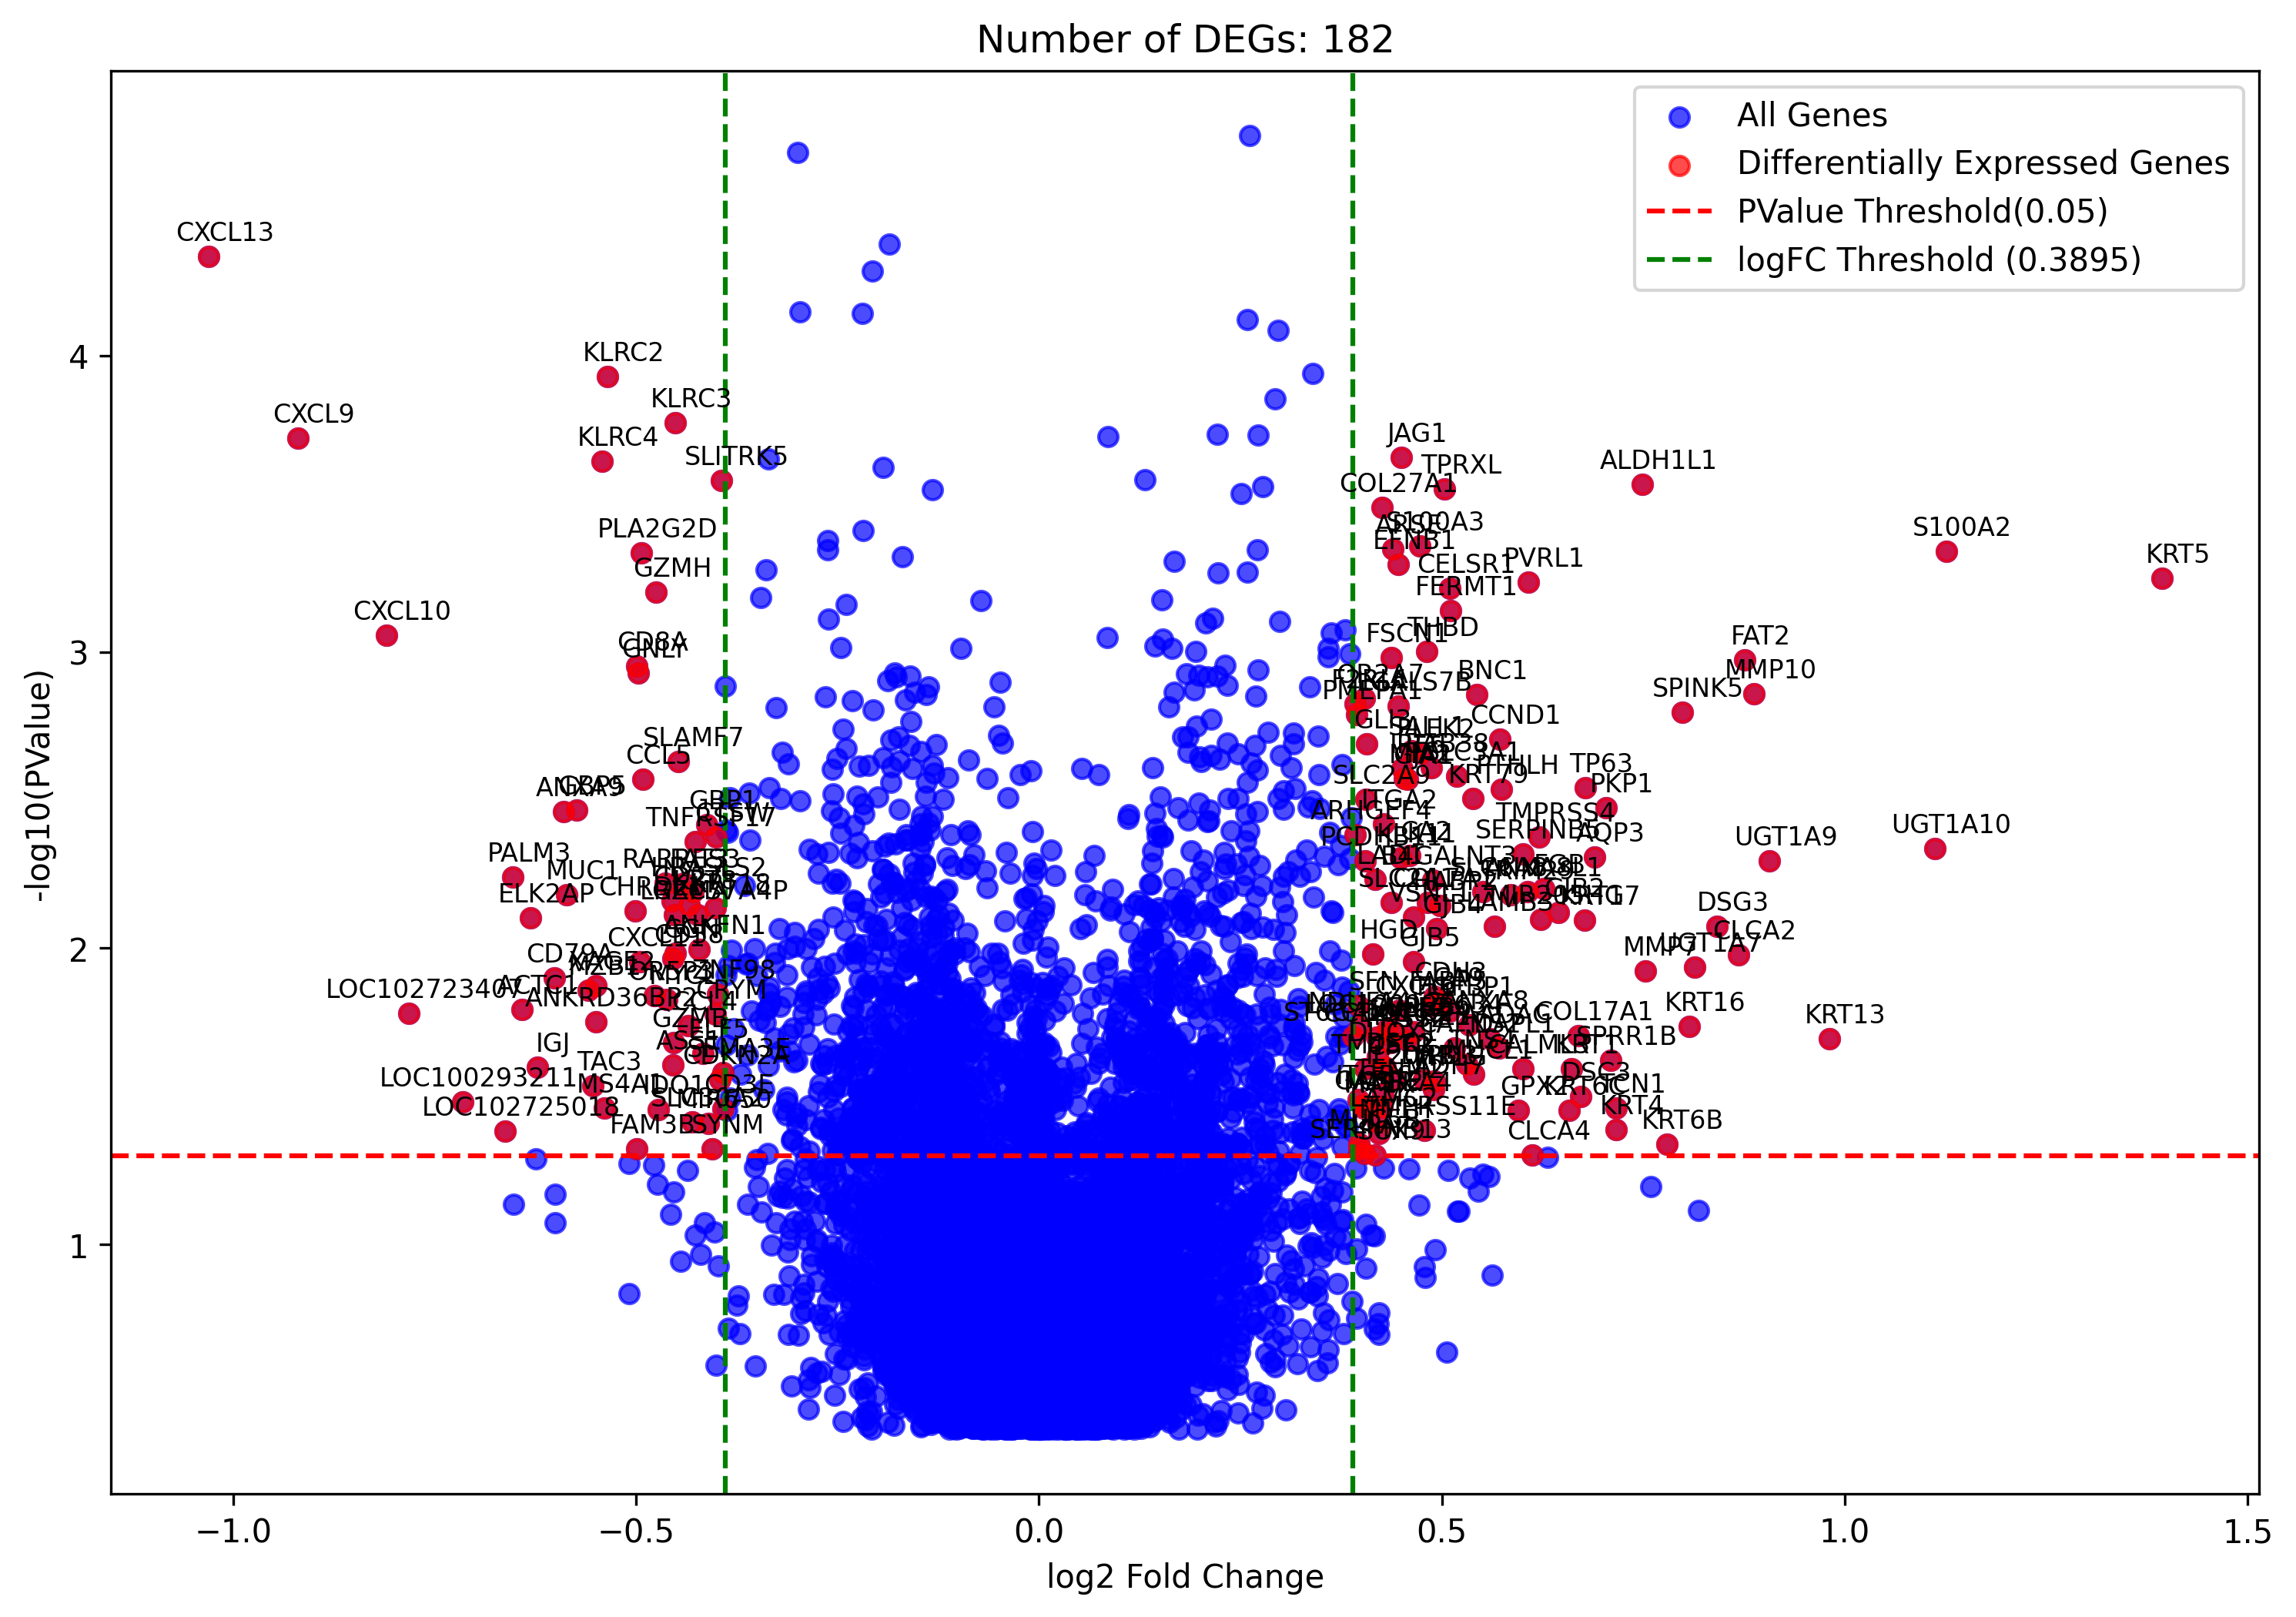

In [18]:
padj_threshold = 0.05
logFC_cutoff = 0.3895
filtered_rows = deg_limma[(deg_limma['logFC'].abs() > logFC_cutoff) & (deg_limma['P.Value'] < padj_threshold)]
selected_row_names = filtered_rows.index.tolist()
alldiff = deg_limma
alldiff = alldiff.rename(columns={'P.Value': 'PValue', 'adj.P.Val': 'adjPValue'})
data = {'logFC': alldiff['logFC'],  'PValue': alldiff['PValue'],'FDR': alldiff['adjPValue']}
volcano_data = pd.DataFrame(data)
diff = alldiff.query('(PValue < @padj_threshold) & ((logFC > @logFC_cutoff) | (logFC < -@logFC_cutoff))')
plt.figure(figsize=(12, 8),dpi = 300)
plt.scatter(volcano_data['logFC'], -np.log10(volcano_data['PValue']), color='blue', alpha=0.7, label='All Genes')
plt.scatter(diff['logFC'], -np.log10(diff['PValue']), color='red', alpha=0.7, label='Differentially Expressed Genes')

for i, row in diff.iterrows():
    plt.annotate(i, (row['logFC'], -np.log10(row['PValue'])),
                 textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8, color='black')

plt.axhline(y=-np.log10(padj_threshold), color='red', linestyle='--', label=f'PValue Threshold({padj_threshold})')
plt.axvline(x=logFC_cutoff, color='green', linestyle='--', label=f'logFC Threshold ({logFC_cutoff})')
plt.axvline(x=-logFC_cutoff, color='green', linestyle='--')
plt.title(f'Number of DEGs: {len(diff)}')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(PValue)')
plt.legend()
plt.show()

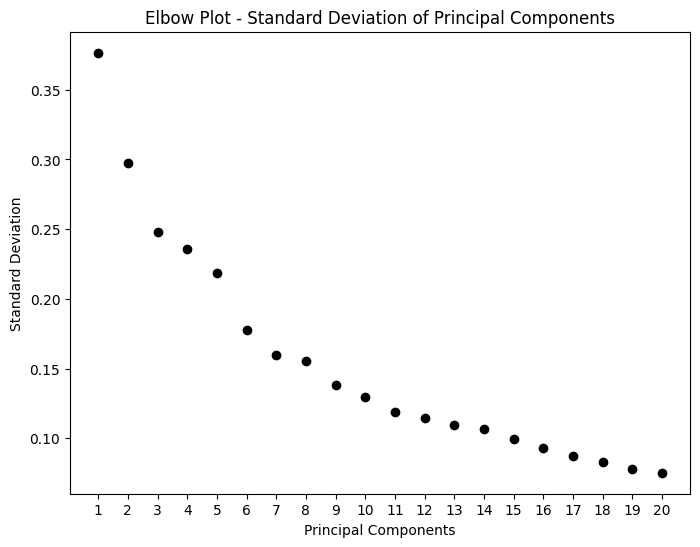

Principal Component 1 Standard Deviation: 0.376481831073761
Principal Component 2 Standard Deviation: 0.2977191209793091
Principal Component 3 Standard Deviation: 0.24788501858711243
Principal Component 4 Standard Deviation: 0.23608174920082092
Principal Component 5 Standard Deviation: 0.21821652352809906
Principal Component 6 Standard Deviation: 0.1778724640607834
Principal Component 7 Standard Deviation: 0.1600877344608307
Principal Component 8 Standard Deviation: 0.15554934740066528
Principal Component 9 Standard Deviation: 0.13825617730617523
Principal Component 10 Standard Deviation: 0.12968796491622925
Principal Component 11 Standard Deviation: 0.11921006441116333
Principal Component 12 Standard Deviation: 0.11468824744224548
Principal Component 13 Standard Deviation: 0.10987070947885513
Principal Component 14 Standard Deviation: 0.10674723237752914
Principal Component 15 Standard Deviation: 0.09924469888210297
Principal Component 16 Standard Deviation: 0.09339630603790283
Princi

In [19]:
all_shap = tpm.transpose()[selected_row_names]
model = xgboost.XGBClassifier(subsample =1, alpha = 2, eta = 0.1).fit(all_shap, [1] * 131 + [0] * 167)
explainer = shap.Explainer(model)
shap_values = explainer(all_shap)

num_components = 20
pca = PCA(n_components=num_components)
pca.fit(shap_values.values)
pca_components = pca.transform(shap_values.values)

std_deviation = np.std(pca_components, axis=0)
num_components = len(std_deviation)

plt.figure(figsize=(8, 6))
plt.scatter(range(1, num_components + 1), std_deviation, color='black', marker='o')
plt.title('Elbow Plot - Standard Deviation of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Standard Deviation')
plt.xticks(np.arange(1, num_components + 1))
plt.show()
for i, std in enumerate(std_deviation):
    print(f"Principal Component {i+1} Standard Deviation: {std}")

In [20]:
def SC_nSNN(A, k, sigma):
    data_size = A.shape[0]
    B = np.zeros((data_size, data_size))  # Create a similarity matrix which is fully connected

    # Compute similarity matrix using Gaussian function
    for i in range(data_size):
        for j in range(data_size):
            B[i, j] = np.exp(-np.sum((A[i, :] - A[j, :]) ** 2) / (2 * sigma ** 2))
            B[j, i] = B[i, j]

    temp = np.array([sorted(row, reverse=True) for row in B])  # Recording the distance in B from big to small
    I = np.argsort(-B, axis=1)  # I is the corresponding id

    for i in range(k, data_size):
        temp[:, i] = 0

    # E is the similarity matrix of the k nearest neighbors
    E = np.zeros((data_size, data_size))
    for i in range(data_size):
        for j in range(k):
            E[i, I[i, j]] = temp[i, j]

    E[np.where(E != 0)] = 1  # Replace nonzero sparse matrix elements with ones
    G = np.copy(E)

    W = np.zeros((data_size, data_size))  # W is the similarity matrix of the shared nearest neighbors

    for i in range(data_size):
        for j in range(i + 1, data_size):
            diff = np.sum(np.abs(G[i, :] - G[j, :])) / 2
            W[i, j] = k - diff
            if G[i, j] != 0 and G[j, i] != 0:
                W[i, j] += 1
            W[i, j] /= k
            W[j, i] = W[i, j]

    return W

def spectral_clustering(similarity_matrix, num_clusters):

    # Normalized Laplacian Matrix
    degrees = np.sum(similarity_matrix, axis=1)
    sqrt_degrees = np.sqrt(degrees)
    normalized_laplacian = np.diag(1.0 / sqrt_degrees) @ (np.diag(degrees) - similarity_matrix) @ np.diag(1.0 / sqrt_degrees)

    # Eigen Decomposition
    eigenvalues, eigenvectors = np.linalg.eig(normalized_laplacian)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvectors = eigenvectors[:, sorted_indices[:num_clusters]]

    # K-means Clustering on Eigenvectors
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(np.real(sorted_eigenvectors))

    return clusters

similarity_matrix = SC_nSNN(pca_components[:, :5],95,1.5)
num_clusters =4
clusters = spectral_clustering(similarity_matrix, num_clusters)

for i in range(len(clusters)):
    if clusters[i] == 0:
        clusters[i] = 1
    elif clusters[i] == 1:
        clusters[i] = 0
for i in range(len(clusters)):
    if clusters[i] == 2:
        clusters[i] = 3
    elif clusters[i] == 3:
        clusters[i] = 2
for i in range(len(clusters)):
    if clusters[i] == 2:
        clusters[i] = 1
    elif clusters[i] == 1:
        clusters[i] = 2
        
def map_cluster_to_color(cluster):
    if cluster == 0:
        return "#007FFF"
    elif cluster == 2:
        return "#FF4B18"
    elif cluster == 1:
        return "#EEC702"
    else:
        return "#008B43"

clusters_color = [map_cluster_to_color(cluster) for cluster in clusters]

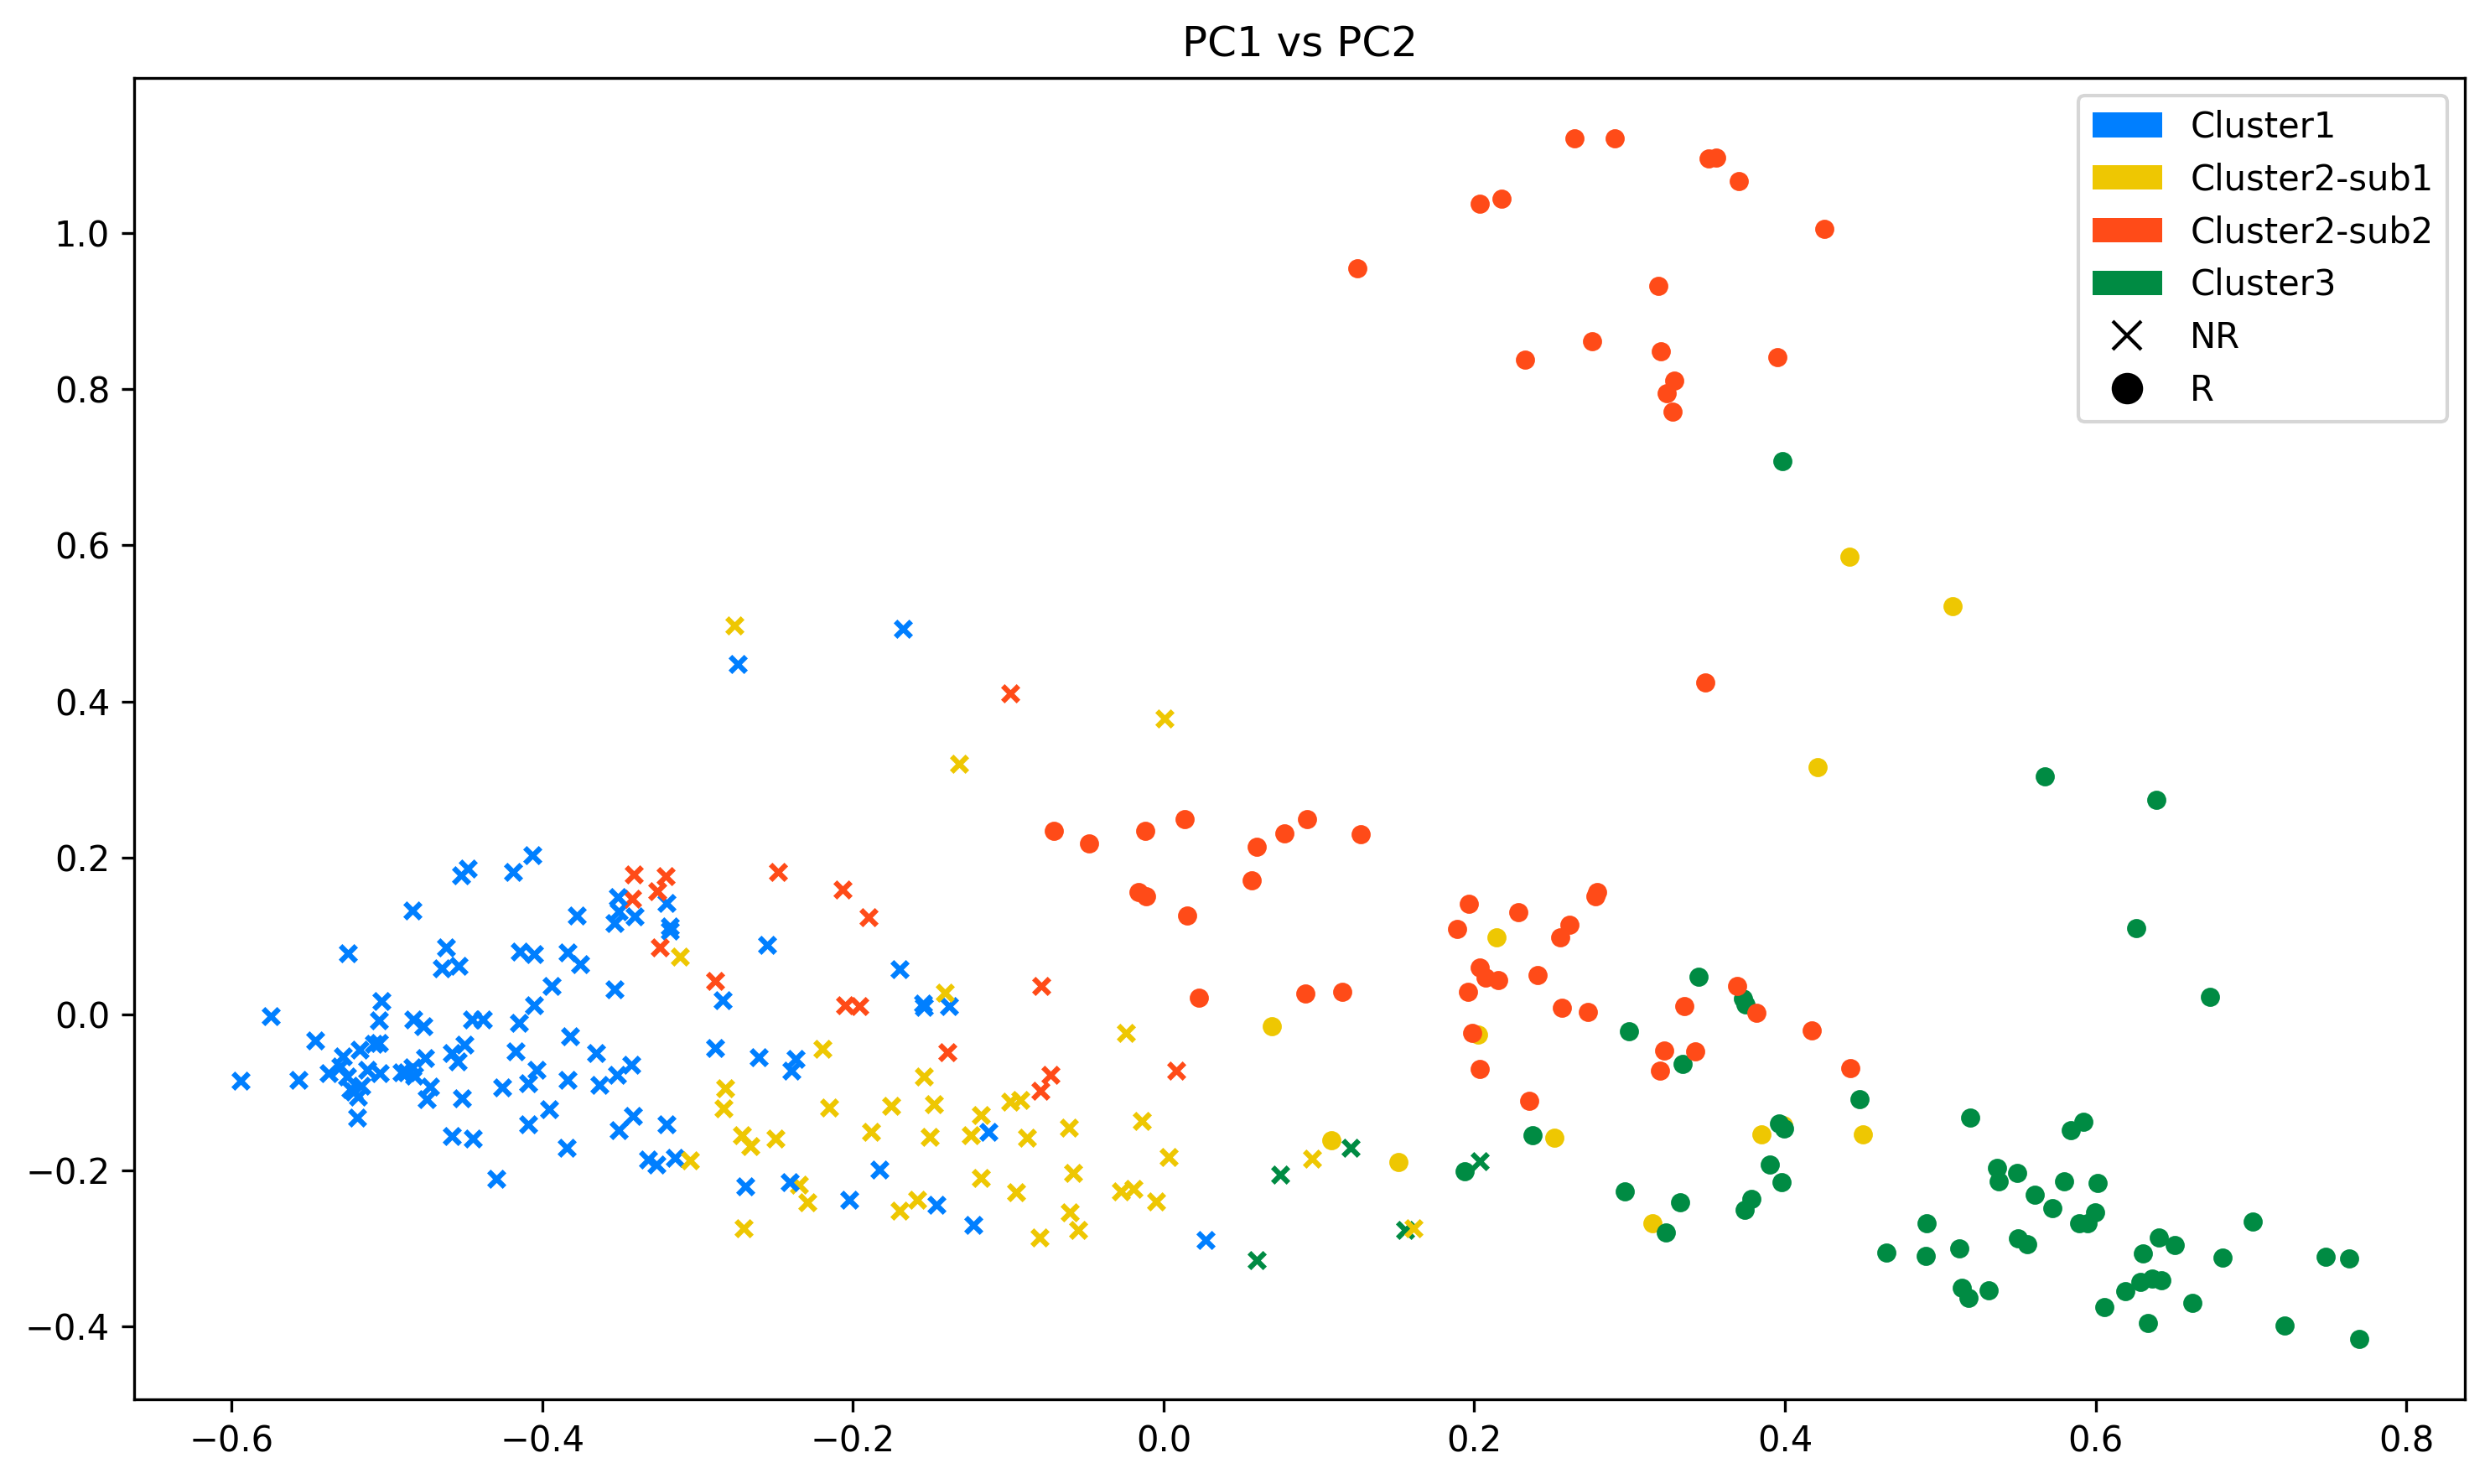

In [21]:
all_shap2 = shap_values.values

pca = PCA(n_components=20)
PCA_dat_all = pca.fit_transform(all_shap2)

color_all = clusters_color
txt = [1] * 131 + [0] * 167  

def get_marker(value):
    return 'x' if value == 0 else 'o'

plt.figure(figsize=(10, 6), dpi=300)
for i in range(len(PCA_dat_all)):
    plt.scatter(PCA_dat_all[i, 0], PCA_dat_all[i, 1], color=color_all[i], marker=get_marker(txt[i]), s=20)
plt.title('PC1 vs PC2')
legend_elements = [
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#007FFF", label='Cluster1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#EEC702", label='Cluster2-sub1'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#FF4B18", label='Cluster2-sub2'),
    mpatches.Rectangle((0, 0), 1, 0.4, facecolor="#008B43", label='Cluster3'),
    plt.Line2D([0], [0], marker='x', color='black', markersize=8, linestyle='None', label='NR'),
    plt.Line2D([0], [0], marker='o', color='black', markersize=8, linestyle='None', label='R')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

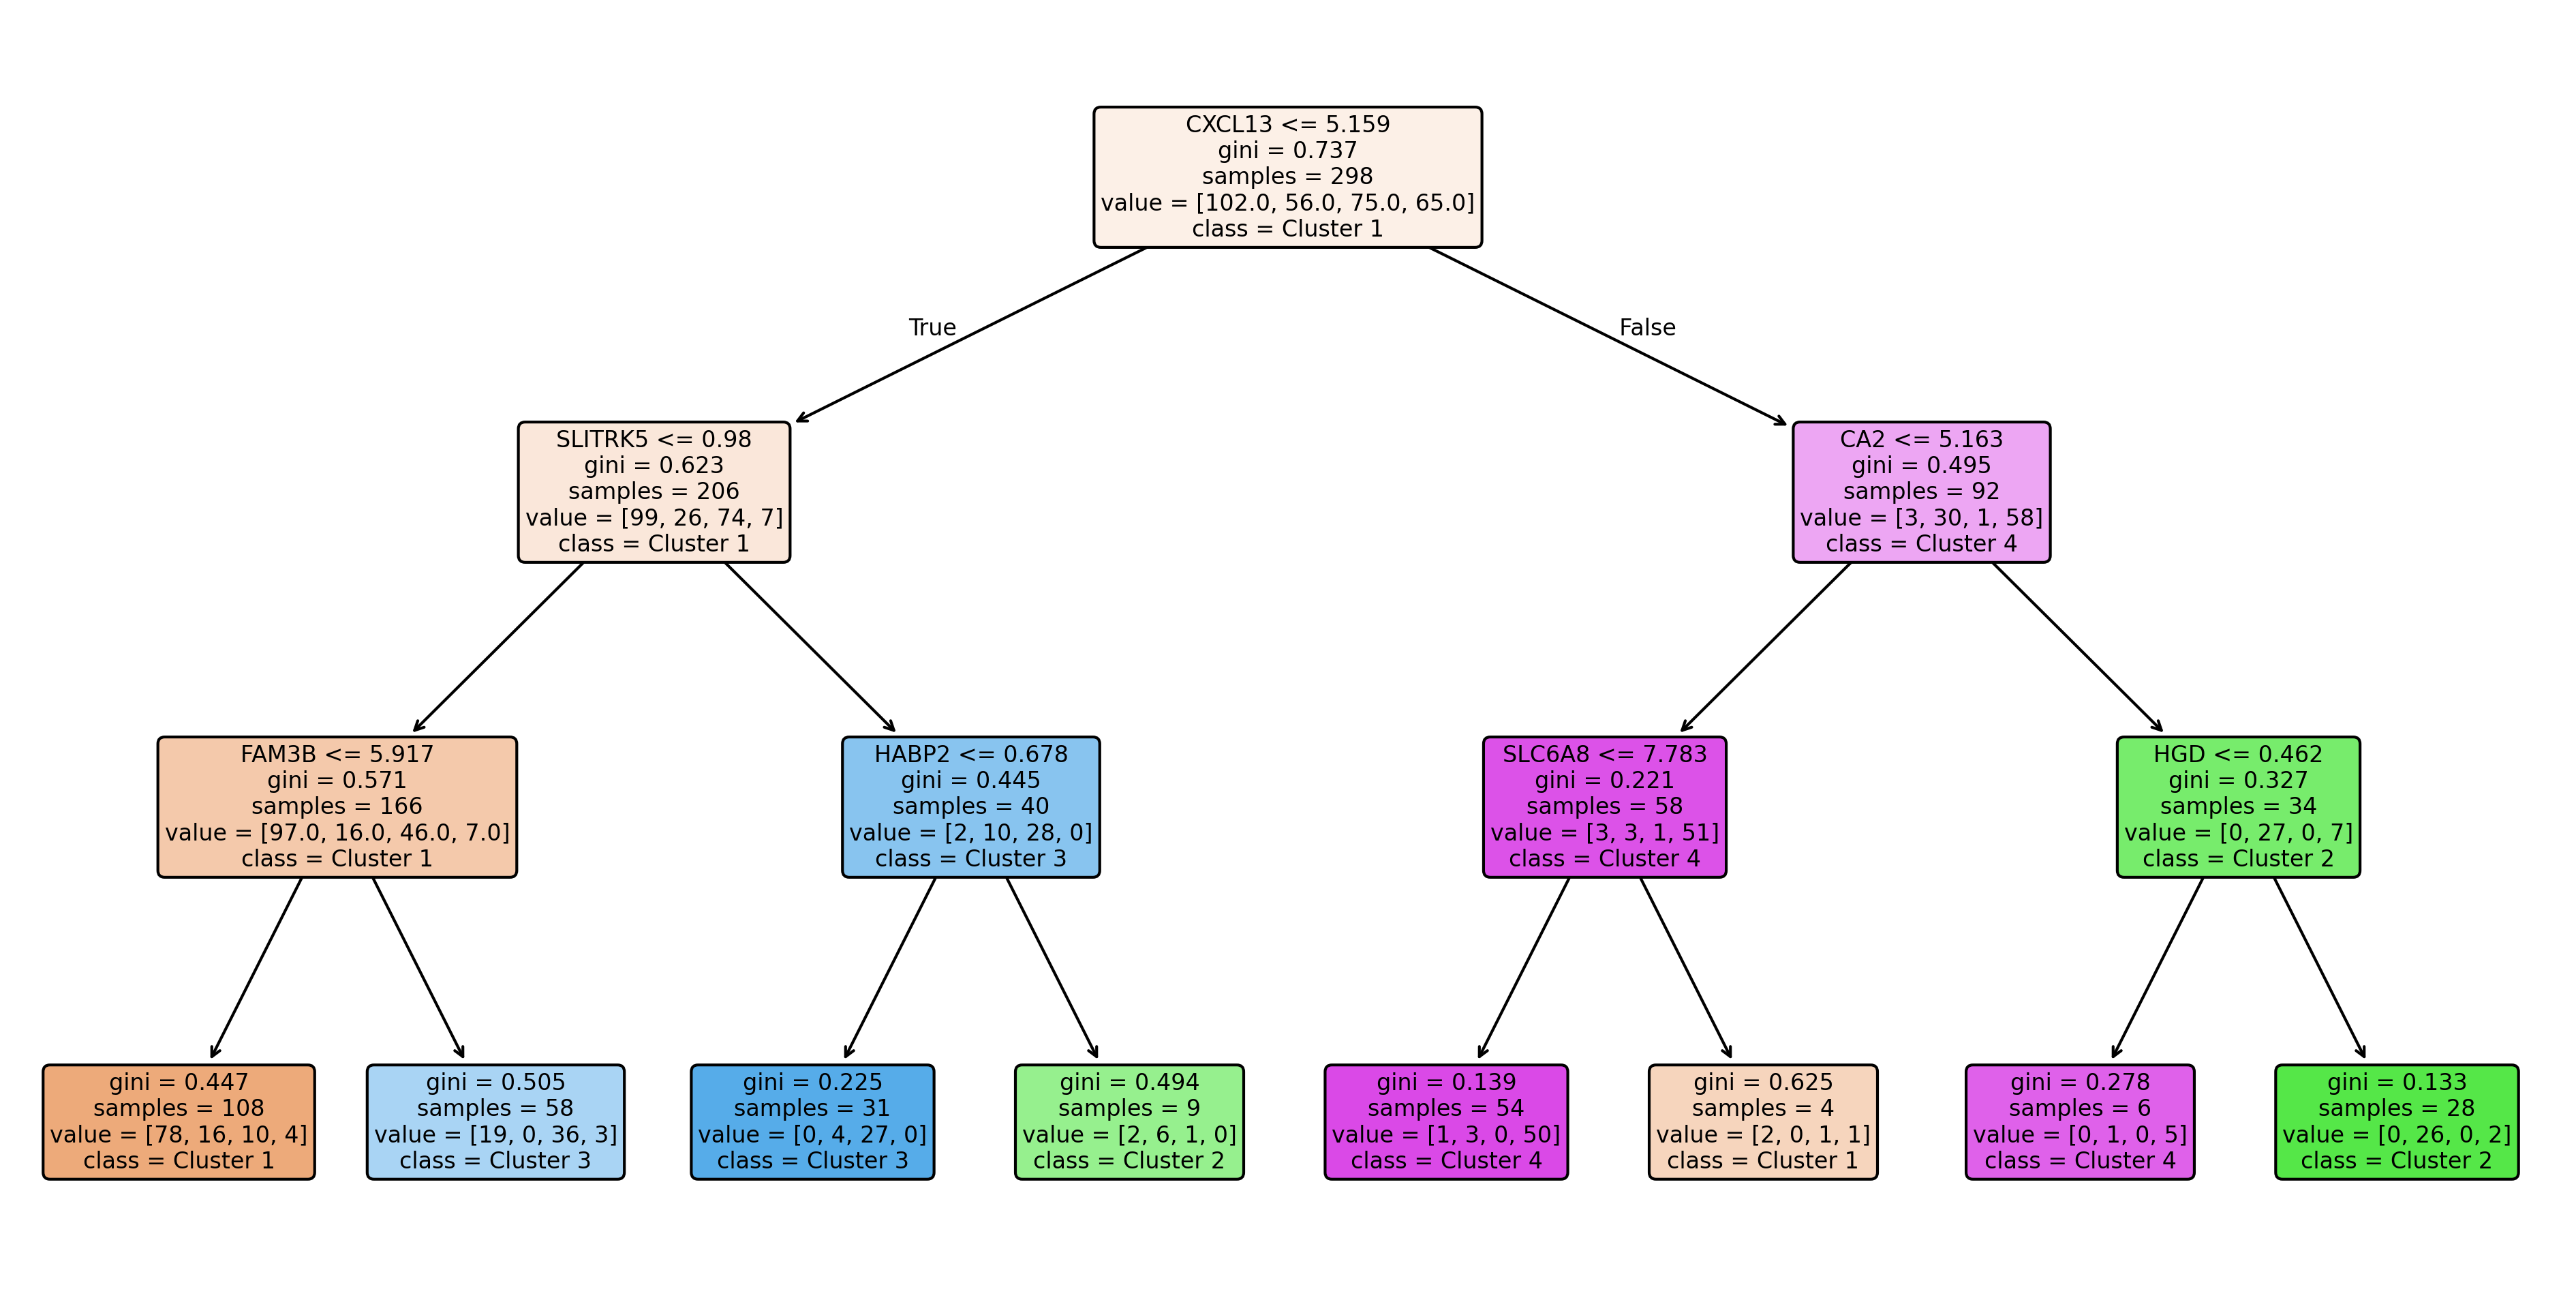

In [22]:
clusters_plus1 = clusters + 1
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(all_shap, clusters_plus1)
plt.figure(figsize=(16, 8),dpi=300)
plot_tree(clf, feature_names=all_shap.columns, class_names=[f"Cluster {i}" for i in np.unique(clusters_plus1)],
          filled=True, rounded=True, fontsize=8)
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


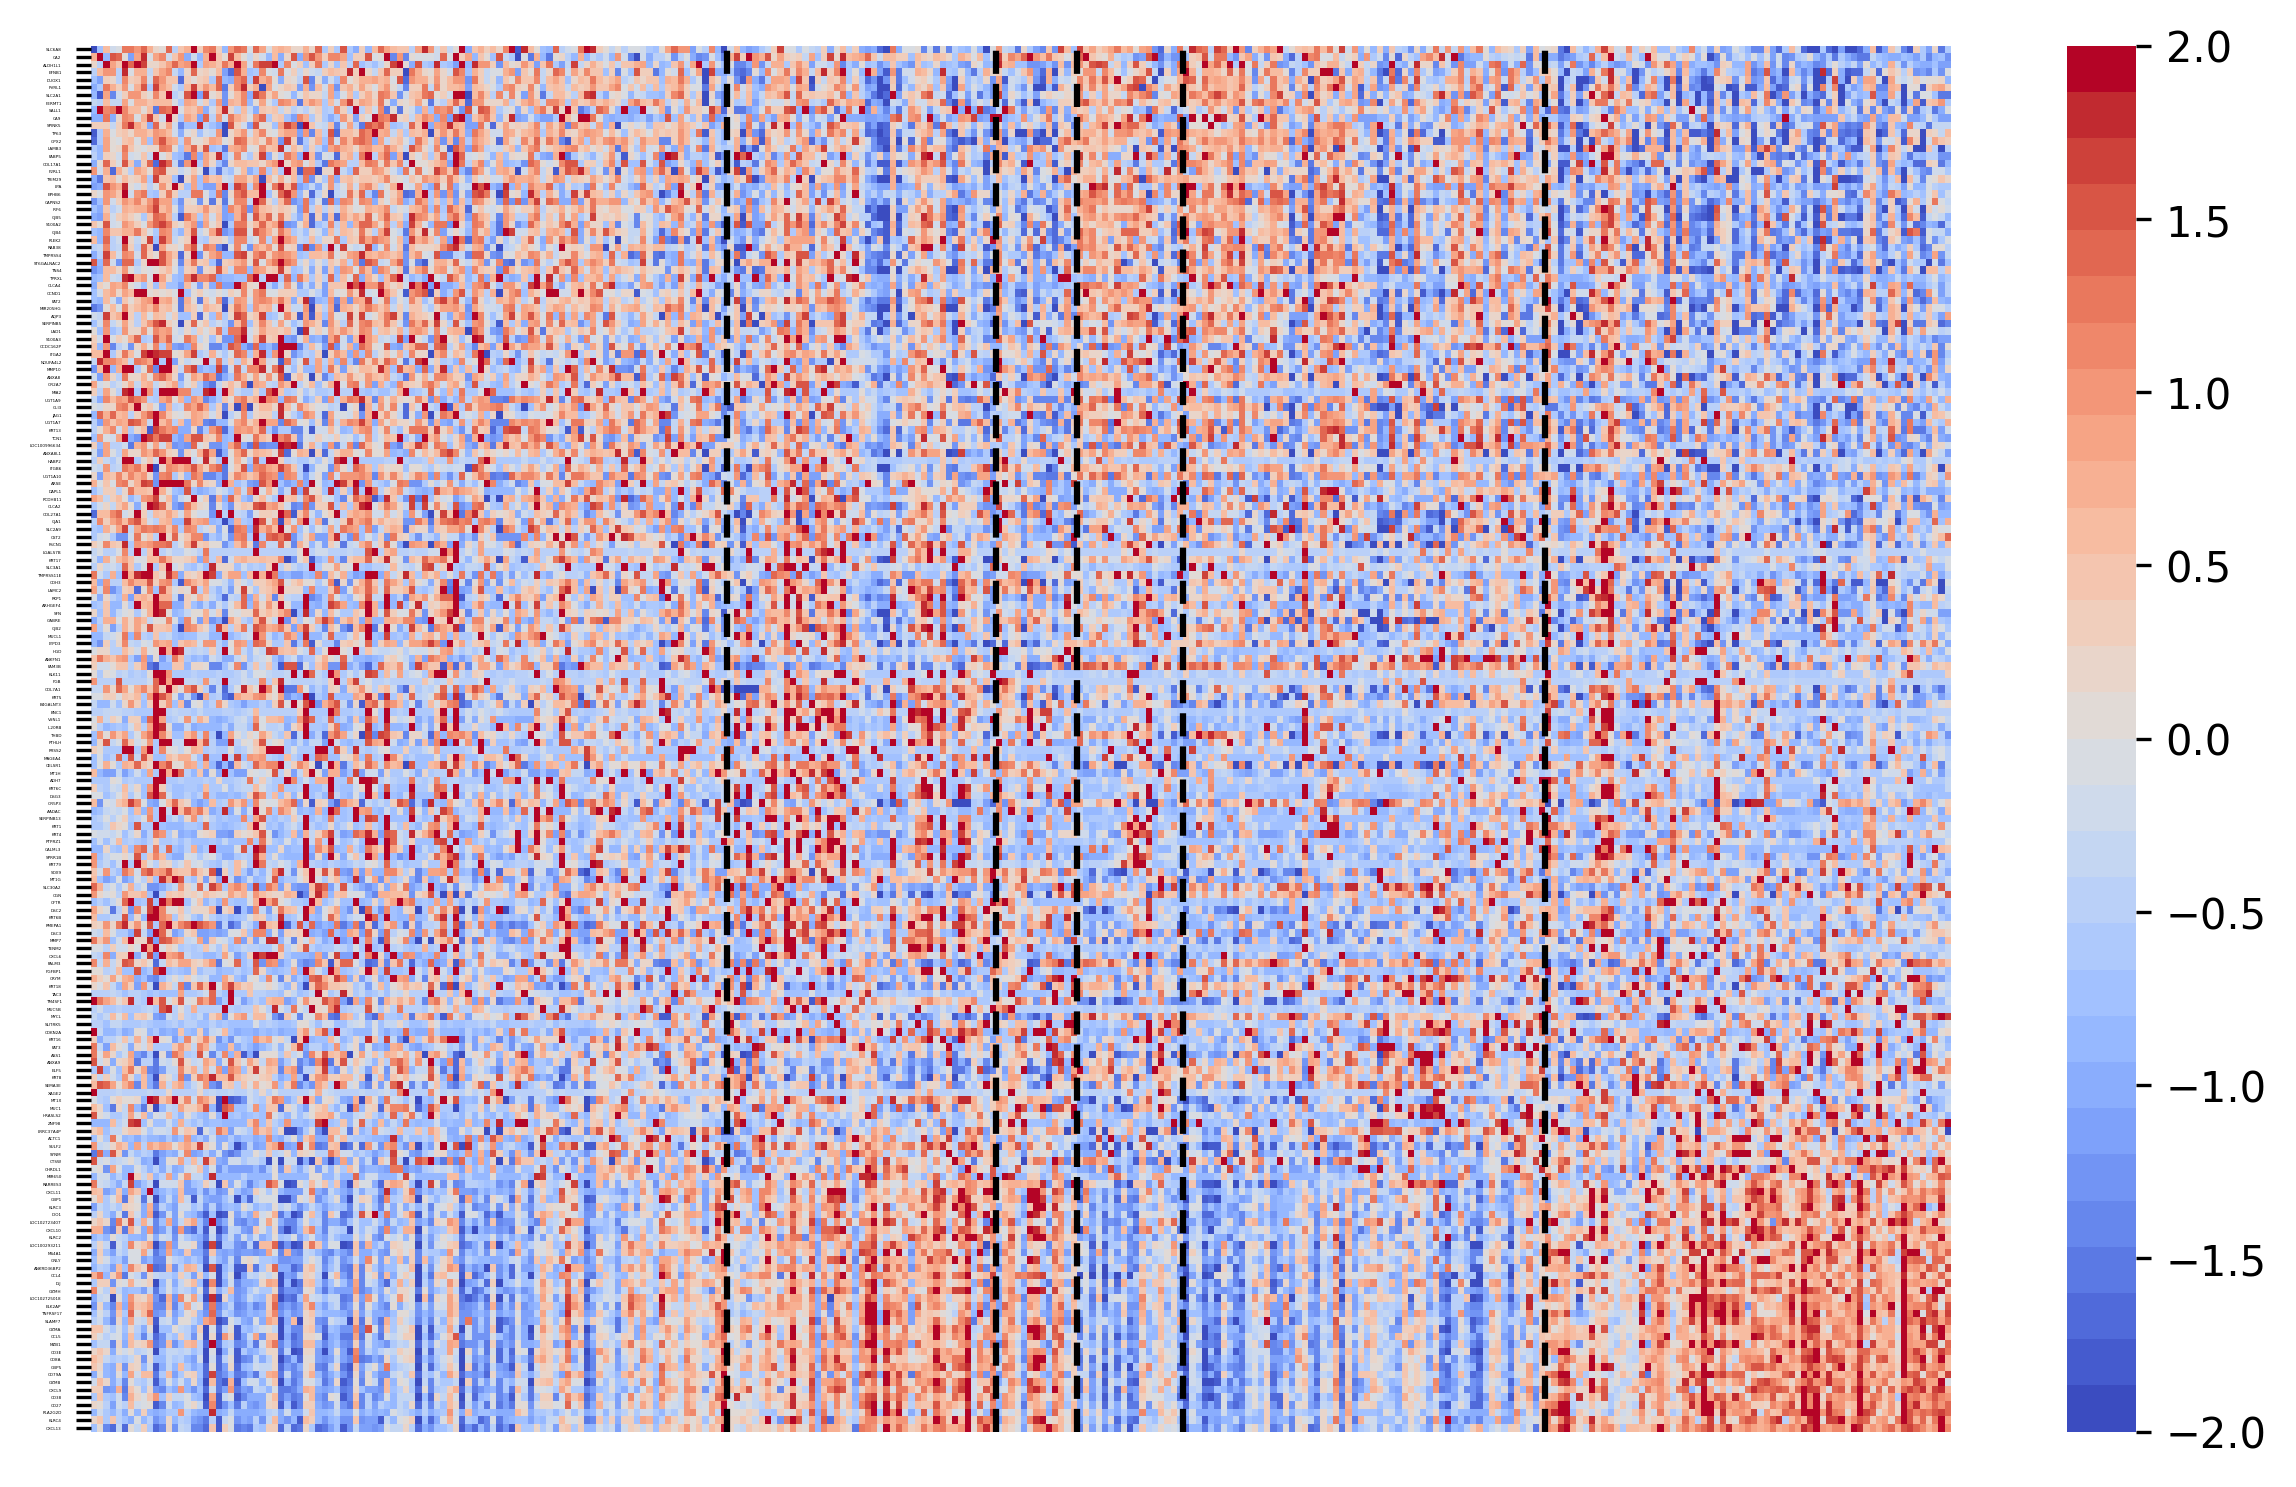

In [26]:
X = all_shap
X['clusters'] = clusters
X['label'] = [1] * 131 + [0] * 167
X['PCA'] = PCA_dat_all[:, 0]

sorted_X = X.sort_values(by=['clusters','label','PCA'])
label_distribution = sorted_X.groupby('clusters')['label'].value_counts()
sorted_X.drop(columns=['clusters','label','PCA'], inplace=True)

sorted_all_shap_zscore = stats.zscore(sorted_X)
sorted_all_shap_zscore = np.clip(sorted_all_shap_zscore, -2, 2)
mean_values = sorted_all_shap_zscore.iloc[-65:, :].mean(axis=0)

sorted_indices = mean_values.sort_values().index

sorted_all_shap_zscore = sorted_all_shap_zscore[sorted_indices]
sorted_all_shap_zscore = sorted_all_shap_zscore.T
plt.figure(figsize=(10, 6), dpi=300)
plt.yticks(fontsize=0.1)
my_col = plt.cm.get_cmap('coolwarm', 30)
ax = sns.heatmap(sorted_all_shap_zscore, cmap=my_col)
ax.axvline(x=label_distribution[0][0] , color='k', linestyle='--')
ax.axvline(x=label_distribution[0][0]  + label_distribution[1][0], color='k', linestyle='--')
ax.axvline(x=label_distribution[0][0]  + label_distribution[1][0]+ label_distribution[1][1], color='k', linestyle='--')
ax.axvline(x=label_distribution[0][0]  + label_distribution[1][0]+ label_distribution[1][1] + label_distribution[2][0], color='k', linestyle='--')
ax.axvline(x=label_distribution[0][0]  + label_distribution[1][0]+ label_distribution[1][1] + label_distribution[2][0] + label_distribution[2][1], color='k', linestyle='--')
plt.xticks([])

plt.show()
